# **Proyecto 3: Filtros**

### Andres Banquez- Melina Villada

## **Objetivos:**

Implementar un flujo de procesamiento que incluya filtrado de las señales y extracción de características espectrales


1. Del artículo:
https://www.nature.com/articles/s41598-020-59821-7

Consultar y explicar los dos métodos de reducción de ruido usados en el artículo: Robust LOESS y Non Local Means (10%), mostrar cómo se podrían implementar en Python (5%)

**Robust LOESS (Locally Estimated Scatterplot Smoothing)**: Este método elimina el ruido de baja frecuencia, como el "baseline wandering", que ocurre debido a movimientos respiratorios o variaciones en la posición del electrodo. LOESS realiza un ajuste local ponderado de polinomios en cada punto de la señal, eliminando las fluctuaciones lentas en el nivel de la señal manteniendo las características de alta frecuencia.

El término “loess” es un acrónimo de “regresión local” y todo el procedimiento es una generalización bastante directa de los métodos tradicionales de mínimos cuadrados para el análisis de datos. El loess es no paramétrico en el sentido de que la técnica de ajuste no requiere una especificación a priori de la relación entre las variables dependientes e independientes.[1]



In [2]:
import numpy as np
import scipy.signal as sis
from scipy.signal import butter, filtfilt, detrend
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
import pywt
import pandas as pd
import os
import shutil


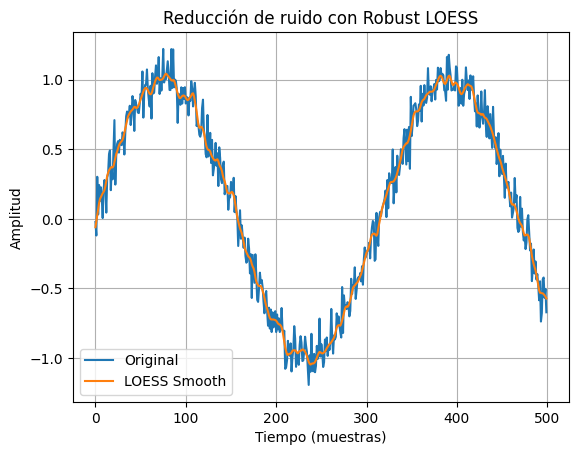

In [3]:
# Ejemplo con una señal ficticia de ECG
ecg_signal = np.sin(np.linspace(0, 10, 500)) + np.random.normal(0, 0.1, 500)
smoothed_signal = lowess(ecg_signal, np.arange(len(ecg_signal)), frac=0.02, is_sorted=True)

# Graficar señal original y suavizada

plt.plot(ecg_signal, label='Original')
plt.plot(smoothed_signal[:, 1], label='LOESS Smooth')
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.title("Reducción de ruido con Robust LOESS")
plt.grid()
plt.legend()
plt.show()


**Non-Local Means (NLM):** Este método se utiliza principalmente para eliminar el ruido de alta frecuencia manteniendo estructuras repetitivas de la señal. Calcula el promedio ponderado de puntos similares dentro de una ventana para cada punto, basado en un parámetro de similitud. Esto preserva detalles como picos característicos de la señal ECG.

El método no local (NLM) es un método reciente de eliminación de ruido que ha recibido mucha atención de la comunidad de procesamiento de señales. Mientras que el filtrado lineal estándar se basa en la correlación espacial local, el principio no local explota el hecho de que pueden aparecer vecindarios similares en cualquier parte de la imagen ypueden contribuir a la eliminación de ruido. [2]



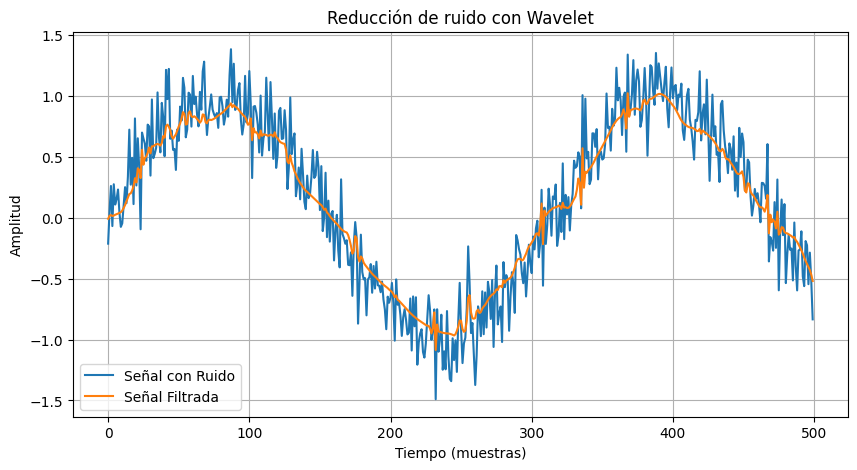

In [4]:


# Señal de ejemplo con ruido
noisy_ecg_signal = np.sin(np.linspace(0, 10, 500)) + np.random.normal(0, 0.2, 500)

# Descomposición en wavelets
coeffs = pywt.wavedec(noisy_ecg_signal, 'db4', level=4)

# Umbralizado de los coeficientes
threshold = np.std(noisy_ecg_signal) / 2
coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

# Reconstrucción de la señal filtrada
denoised_signal = pywt.waverec(coeffs, 'db4')

# Graficar señal original y denoised
plt.figure(figsize=(10, 5))
plt.plot(noisy_ecg_signal, label='Señal con Ruido')
plt.plot(denoised_signal, label='Señal Filtrada')
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.title("Reducción de ruido con Wavelet")
plt.legend()
plt.grid()
plt.show()







2. Descargar los datos ECGData.zip de:
https://figshare.com/collections/ChapmanECG/4560497/1

De la base de datos extraer los registros que correspondan a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Esta información está en el archivo Diagnostics.xlsx

In [5]:
diagnostics_path = 'Diagnostics.xlsx'
diagnostics_df = pd.read_excel(diagnostics_path)
sbyafib_df=diagnostics_df[diagnostics_df['Rhythm'].isin(['AFIB', 'SB'])]
needed_files = sbyafib_df['FileName'].tolist()

In [6]:
data_folder = r"C:\Users\andre\OneDrive\Desktop\ECGData"
destination_folder = r"C:\Users\andre\OneDrive\Desktop\ECGFiltered"
os.makedirs(destination_folder, exist_ok=True)

for file_name in needed_files:
    source_path = os.path.join(data_folder, f"{file_name}.csv") 
    
    if os.path.exists(source_path):
        # Cargar el archivo CSV
        ecg_data = pd.read_csv(source_path)
        
        if 'II' in ecg_data.columns:
            derivacion_II = ecg_data['II']
            save_path = os.path.join(destination_folder, f"{file_name}_derivacion_II.csv")
            derivacion_II.to_csv(save_path, index=False)
            print(f"Derivación II extraída y guardada para: {file_name}.csv")
        else:
            print(f"Columna 'Derivacion_II' no encontrada en el archivo: {file_name}.csv")
    else:
        print(f"Archivo no encontrado: {file_name}.csv")

Derivación II extraída y guardada para: MUSE_20180113_171327_27000.csv
Derivación II extraída y guardada para: MUSE_20180112_073319_29000.csv
Derivación II extraída y guardada para: MUSE_20180113_121940_44000.csv
Derivación II extraída y guardada para: MUSE_20180112_120347_79000.csv
Derivación II extraída y guardada para: MUSE_20180114_075026_69000.csv
Derivación II extraída y guardada para: MUSE_20180114_075128_92000.csv
Derivación II extraída y guardada para: MUSE_20180118_174026_42000.csv
Derivación II extraída y guardada para: MUSE_20180115_125443_25000.csv
Derivación II extraída y guardada para: MUSE_20180113_134825_04000.csv
Derivación II extraída y guardada para: MUSE_20180114_070718_20000.csv
Derivación II extraída y guardada para: MUSE_20180115_133559_70000.csv
Derivación II extraída y guardada para: MUSE_20180113_133901_16000.csv
Derivación II extraída y guardada para: MUSE_20180113_071734_35000.csv
Derivación II extraída y guardada para: MUSE_20180114_121218_64000.csv
Deriva

3. Consultar que otros tipos de señales wavelet se pueden usar para el análisis de señales ECG y adaptar el código del filtro wavelet que se entrega en el curso de acuerdo a la consulta (10%)

Para el análisis de señales ECG, se pueden emplear varias familias de wavelets adicionales, cada una con características específicas que pueden mejorar la extracción de información en distintos aspectos de la señal. Algunas opciones incluyen:

Wavelet de Daubechies (db): Esta familia es popular para ECG por su suavidad y sus similitudes con las características de la señal, especialmente las versiones como db4, db6, y db8.

Wavelet de Symlet (sym): Ofrece mejor simetría y es adecuada para detectar transitorios y componentes de baja frecuencia en ECG. Ejemplos útiles son sym4 y sym8.

Wavelet de Coiflet (coif): Ideal para captar detalles en señales que tienen estructuras complejas en el dominio del tiempo-frecuencia, como coif3 y coif5.

Wavelet de Biorthogonal (bior): Útil para análisis multi-resolución en ECG, ya que mantiene buena precisión en los bordes y puede capturar transiciones bruscas.

In [7]:

def filtro_wavelet_modificado(senal, wavelet_type='db6', nivel=8):
    '''
    Filtra la señal usando una descomposición wavelet y reconstrucción, permitiendo
    seleccionar diferentes tipos de wavelet (db6, sym3, coif3, meyer, etc.).

    Parámetros:
    - senal: np.array, señal de entrada a filtrar.
    - wavelet_type: str, tipo de wavelet a utilizar (por defecto 'db6').
    - nivel: int, nivel de descomposición de la wavelet.

    Retorna:
    - Señal reconstruida después del filtrado wavelet.
    '''
    senal= senal.flatten()
    coeficientes = pywt.wavedec(senal, wavelet=wavelet_type, level=nivel)
    
    # Aplicar umbral a los coeficientes de detalle
    sigma = np.median(np.abs(coeficientes[-1])) / 0.6745
    umbral = sigma * np.sqrt(2 * np.log(len(senal)))
    coeficientes_filtrados = [pywt.threshold(c, umbral, mode='soft') for c in coeficientes]
    
    # Reconstruir la señal
    senal_filtrada = pywt.waverec(coeficientes_filtrados, wavelet=wavelet_type)
    return senal_filtrada


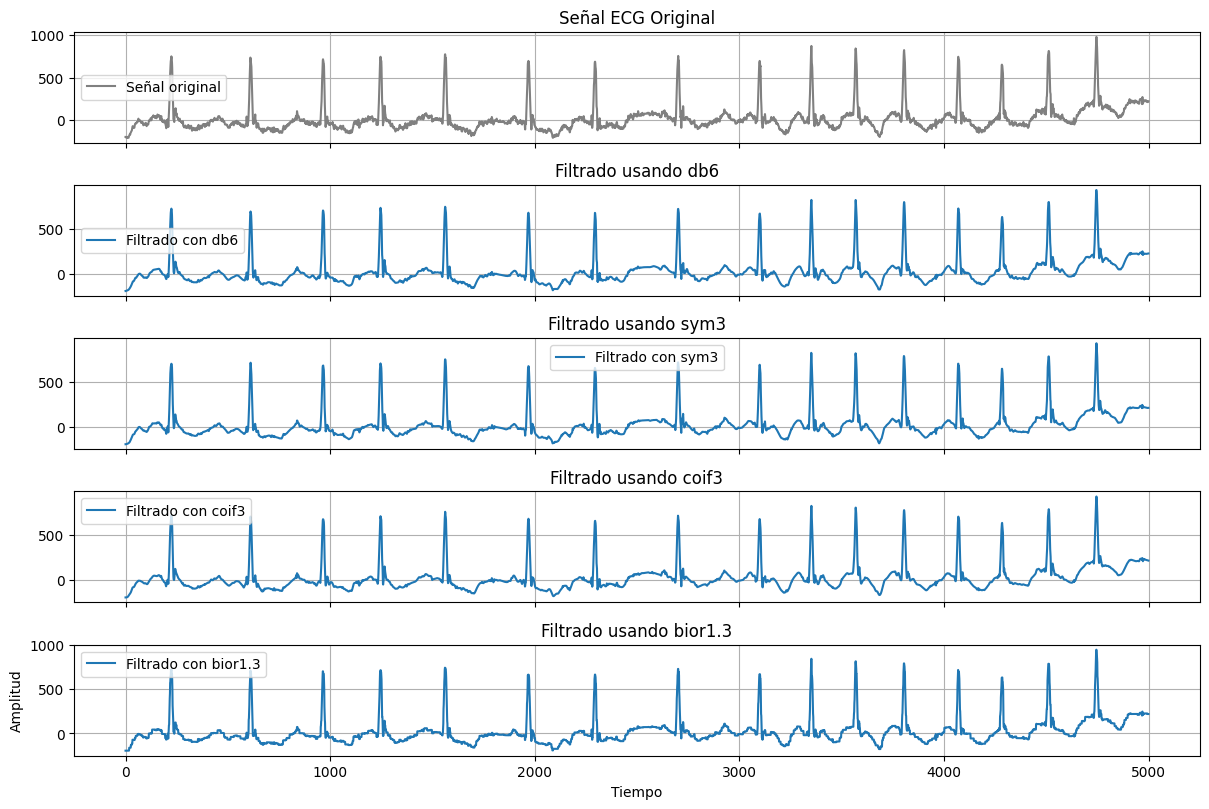

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar la señal ECG desde el archivo CSV
senal_ecg = r'Derivacion_II_Filtrados\MUSE_20180115_133327_45000_derivacion_II.csv'
data = pd.read_csv(senal_ecg)
data = np.array(data).flatten()

# Lista de wavelets a probar
wavelet_types = ['db6', 'sym3', 'coif3', 'bior1.3']

resultados = {}
for wavelet in wavelet_types:
    resultado_filtrado = filtro_wavelet_modificado(data, wavelet_type=wavelet)
    resultados[wavelet] = resultado_filtrado

# Crear una figura con subplots
n_wavelets = len(wavelet_types)
fig, axes = plt.subplots(n_wavelets + 1, 1, figsize=(12, 8), sharex=True)

# Graficar la señal original en el primer subplot
axes[0].plot(data, label='Señal original', color='gray')
axes[0].set_title('Señal ECG Original')
axes[0].legend()
axes[0].grid()


for ax, wavelet in zip(axes[1:], resultados.keys()):
    ax.plot(resultados[wavelet], label=f'Filtrado con {wavelet}')
    ax.set_title(f'Filtrado usando {wavelet}')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.show()


4. Escoger 10 señales al azar y aplicar un flujo de procesamiento que conste de:

Flujo 1

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Flujo 2

1. Detrend
2. Filtro wavelet modificado del punto 3
3. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Flujo 3

1. Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR
2. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3 (20%)

Con el flujo seleccionado procesar las señales de la base de datos ECGData.zip derivación II. En este punto deberíamos estar en el mismo punto donde partimos en el proyecto 2, con señales filtradas.

A las señales filtradas con el flujo seleccionado aplicar el procesamiento de normalización usado en el proyecto 2.

In [9]:
directory = r"C:\Users\andre\OneDrive\Desktop\ECGFiltered"

output_directory = r'Derivacion_II_Filtrados'
os.makedirs(output_directory, exist_ok=True)

existing_files = [f for f in os.listdir(output_directory) if f.endswith('.csv')]
if len(existing_files) >= 10:
    print("Ya existen 10 o más archivos CSV en el directorio de destino. No se realizará una nueva selección.")
else:
    # Obtener una lista de todos los archivos CSV en el directorio de entrada
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Seleccionar aleatoriamente 10 archivos CSV
    selected_files = np.random.choice(csv_files, 10, replace=False)

# Copiar los archivos seleccionados al directorio de destino
    for file in selected_files:
        source_path = os.path.join(directory, file)
        destination_path = os.path.join(output_directory, file)
        shutil.copy(source_path, destination_path)

    print("Se han seleccionado y copiado 10 archivos CSV aleatoriamente.")


Ya existen 10 o más archivos CSV en el directorio de destino. No se realizará una nueva selección.


Se eligen filtros FIR debido a que siempre son estables y pueden diseñarse para tener una respuesta de fase lineal, lo que es crucial en aplicaciones donde se necesita preservar la forma de la señal, como en nuestro caso de ECG. Además, los FIR tienen un diseño más sencillo y son menos susceptibles a problemas de precisión numérica, lo que los hace más adecuados para implementaciones digitales. Aunque los FIR pueden requerir más coeficientes y ser más costosos en términos computacionales, su estabilidad garantizada y la capacidad de mantener una fase lineal a menudo los hacen preferibles en sistemas donde estos factores son críticos.

Como se dijo antes requieren una MUY buena cantidad de coeficientes para realizar este trabajo, por tanto se decidió hacerlo con 500, para evitar colapsar la cantidad de coeficientes que se generarían, con esto se obtiene entonces un Δ𝐹 de:

Δ𝐹 = 3,3/500 = 0.0066*500 = 3.3 Hz

In [10]:
#Filtro pasa-altas FIR
def filtro_pasa_altas(data, fs, cutoff=0.5, order=1650):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b,a = sis.firwin(order+1, normal_cutoff, pass_zero = 'highpass', window = 'hamming'),1
    return sis.filtfilt(b, a, data)


def filtro_pasa_bajas(data, fs, cutoff=50, order=1650):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b,a = sis.firwin(order+1, normal_cutoff, pass_zero = 'lowpass', window = 'hamming'),1
    return sis.filtfilt(b, a, data)

# Procesamiento de señal con Flujo 1
def flujo_1(data, fs):
    data_hp = filtro_pasa_altas(data, fs)
    data_wavelet = filtro_wavelet_modificado(data_hp)
    data_lp = filtro_pasa_bajas(data_wavelet, fs)
    return data_lp

# Procesamiento de señal con Flujo 2
def flujo_2(data, fs):
    data_detrended = detrend(data)
    data_wavelet = filtro_wavelet_modificado(data_detrended)
    data_lp = filtro_pasa_bajas(data_wavelet, fs)
    return data_lp

# Procesamiento de señal con Flujo 3
def flujo_3(data, fs):
    data_hp = filtro_pasa_altas(data, fs)
    data_lp = filtro_pasa_bajas(data_hp, fs)
    return data_lp



In [11]:
fs = 500

archivos = [pd.read_csv(os.path.join('Derivacion_II_Filtrados',file)) for file in os.listdir('Derivacion_II_Filtrados')];
# Aplicar cada flujo
resultados_flujo_1 = [flujo_1(senal.II, fs) for senal in archivos];
resultados_flujo_2 = [flujo_2(senal.II, fs) for senal in archivos];
resultados_flujo_3 = [flujo_3(senal.II, fs) for senal in archivos];


In [12]:
[i.split('_derivacion_II')[0] for i in os.listdir('Derivacion_II_Filtrados')]

['MUSE_20180112_122550_52000',
 'MUSE_20180112_134549_62000',
 'MUSE_20180112_165324_19000',
 'MUSE_20180113_135529_57000',
 'MUSE_20180113_184924_57000',
 'MUSE_20180114_124337_89000',
 'MUSE_20180114_133658_32000',
 'MUSE_20180115_133327_45000',
 'MUSE_20180116_134125_04000',
 'MUSE_20180712_160537_97000']

In [13]:
ruta = r'C:\Users\andre\Downloads\ECGDataDenoised\ECGDataDenoised'
archivos_prefiltrados = [pd.read_csv(os.path.join(ruta, file), names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']).II for file in os.listdir(ruta) if file.split('.')[0] in [i.split('_derivacion_II')[0] for i in os.listdir('Derivacion_II_Filtrados')]]
len(archivos_prefiltrados)

10

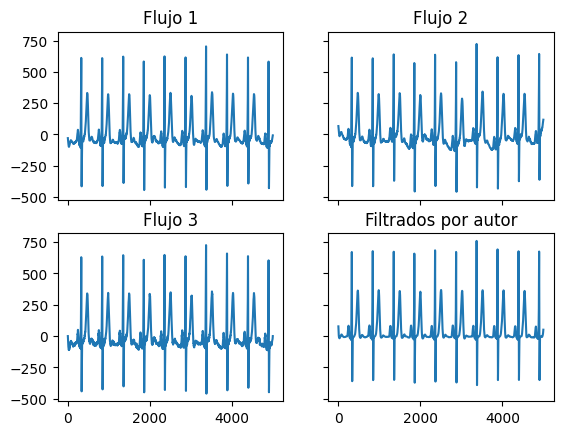

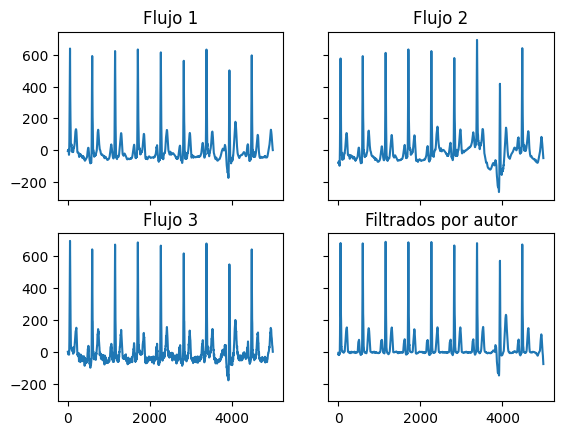

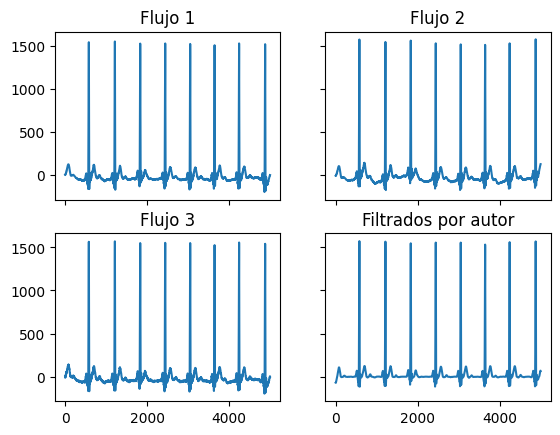

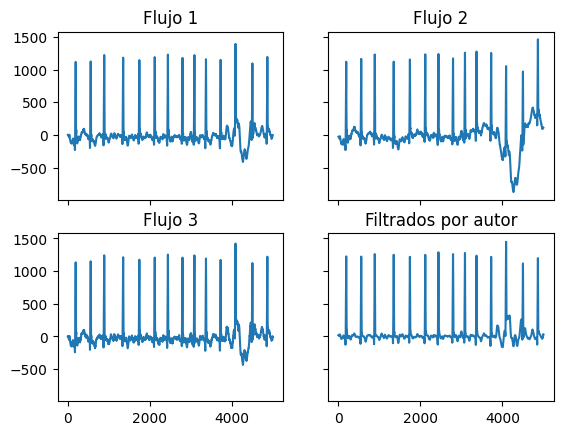

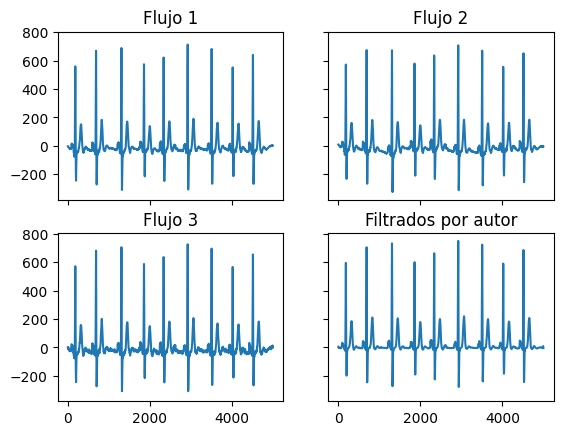

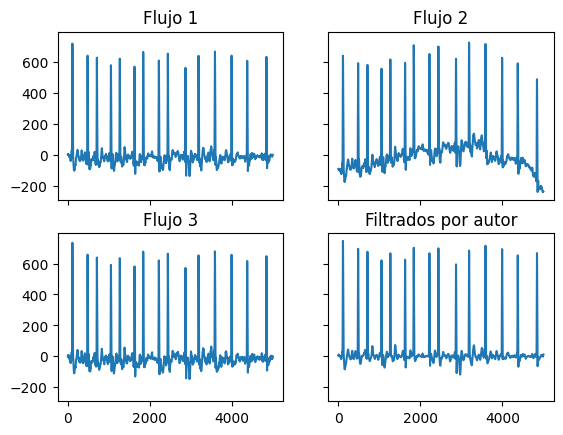

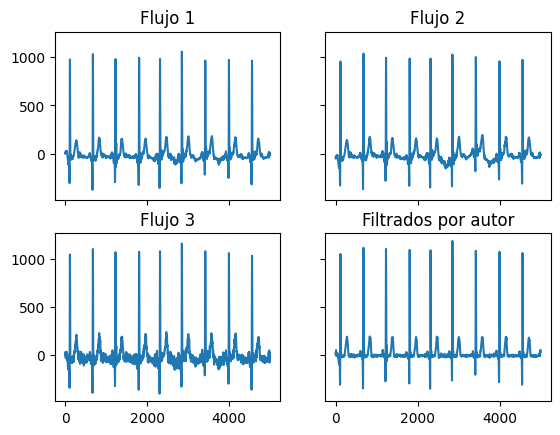

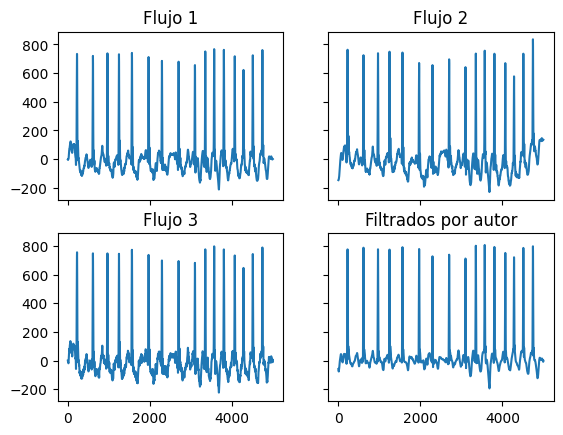

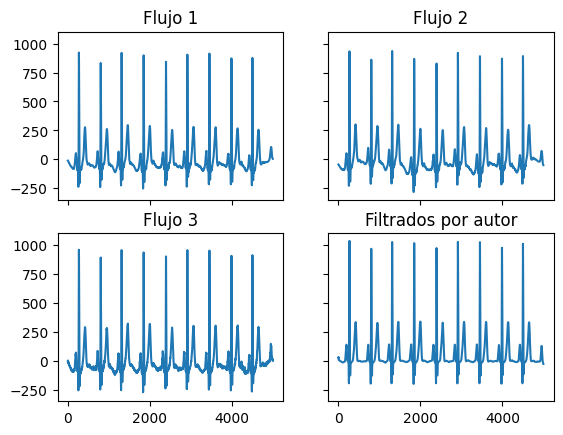

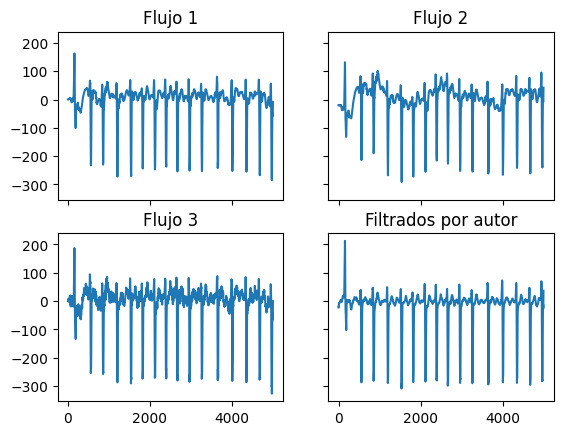

In [14]:
for i in range(10):
    fig, ax = plt.subplots(2,2, sharey = True, sharex = True)
    ax[0,0].plot(resultados_flujo_1[i])
    ax[0,0].set_title('Flujo 1')
    ax[0,1].plot(resultados_flujo_2[i])
    ax[0,1].set_title('Flujo 2')
    ax[1,0].plot(resultados_flujo_3[i])
    ax[1,0].set_title('Flujo 3')
    ax[1,1].plot(archivos_prefiltrados[i])
    ax[1,1].set_title('Filtrados por autor')


Es evidente que, aunque en algunos casos el Flujo 2 se asemeja bastante al Flujo 1 en cuanto a la forma de la señal ECG, presenta alteraciones significativas en ciertos registros, lo cual introduce distorsiones no deseadas que pueden afectar la interpretación visual. Por otro lado, el Flujo 3 parece retener una cantidad considerable de ruido de alta frecuencia, lo que compromete su eficacia en la reducción de ruido.

Debido a estas observaciones, se ha decidido utilizar el Flujo 1 para el procesamiento de la totalidad de los archivos, ya que logra un equilibrio óptimo al mantener la estructura esencial de la señal ECG y reducir eficazmente el ruido sin introducir alteraciones indeseadas.

In [15]:
fs = 500

archivos = [[file, pd.read_csv(os.path.join(directory,file))] for file in os.listdir(directory)]
resultados_filtrados = [[senal[0], flujo_1(senal[1].II, fs)] for senal in archivos]

5. Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch (15%)

Para este caso volvemos a definir la función compress, ya que será necesario al tener en cuenta que el resultado del proyecto 2 posee tanto compress como detrend entonces para evitar que estos afecten el resultado, se aplicarán tambien a los datos post-filtrado de este proyecto.

In [16]:
def compress(timeseries: np.ndarray) -> np.ndarray:
  """
    Normaliza la señal recibida, poniendola entre 0 y 1.
  """
  max = timeseries.max()
  min = timeseries.min()
  return (timeseries - min) / (max - min)

6. Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP):

In [17]:
diagnostics_path = 'Diagnostics.xlsx'
diagnostics_df = pd.read_excel(diagnostics_path)

In [19]:
def extractNGraph(signal: np.ndarray, graph: bool = True) -> dict:
    FT = np.fft.fft(signal)
    FT = np.abs(FT[:len(FT)//2])
    freqs = np.fft.fftfreq(len(signal), 1/500)
    freqs = freqs[:len(freqs)//2]
    power = np.abs(FT)**2
    maxV = np.argmax(power)
    maxFf = round(freqs[maxV], 5)
    max = power[maxV]  
    maxF = FT[maxV]  
    if graph:   
        plt.figure()
        plt.plot(freqs, FT)
        plt.axvline(maxFf, color = 'r', linestyle = '--', label = 'Maxima Freq')
        plt.text(maxFf, maxF, f' {power[maxV]} es el valor máximo de potencia')
    return {'MFrecuencia' : maxFf}

In [20]:
def FullDF(lista: list[list[str, pd.Series]]):
    a = 0
    dataframe = pd.DataFrame(columns=['patologia', 'MFrecuencia'])
    for csv in lista:
        row = diagnostics_df[diagnostics_df.FileName == csv[0].split('_derivacion_II')[0]]
        name = row.FileName.to_numpy()[0]
        patologia = row.Rhythm.to_numpy()[0]
        maximos = extractNGraph(csv[1], graph = False)
        total = {
            'patologia': patologia
        }
        total.update(maximos)
        dataframe.loc[name] = total
    return dataframe
new_df = FullDF(resultados_filtrados)

In [21]:
new_df.head()

,patologia,MFrecuencia
MUSE_20180111_155154_74000,AFIB,9.7
MUSE_20180111_155203_15000,AFIB,2.7
MUSE_20180111_155758_17000,SB,3.7
MUSE_20180111_155839_67000,SB,1.0
MUSE_20180111_155859_36000,SB,0.9


7. Comparar los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva: gráficos y pruebas de hipótesis (15%) Discuta si hay más diferencias entre los tipos de señales con el flujo de procesamiento propuesto respecto al que se trabajó en el proyecto 2.

In [22]:
old_df = pd.read_csv('../Proyecto_2/datos.csv').iloc[:, :2]
old_df.head()

,patologia,MFrecuencia
0,AFIB,9.7
1,AFIB,2.7
2,AFIB,3.4
3,SB,3.7
4,SB,2.9


<Axes: title={'center': 'AFIB NEW'}, ylabel='Frequency'>

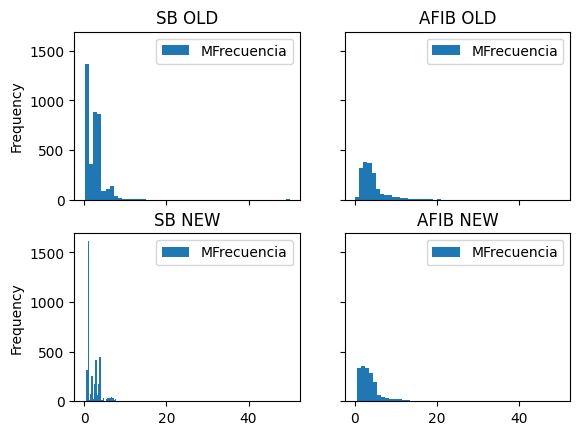

In [23]:
fig, axs = plt.subplots(2,2, sharey = True, sharex = True)
old_df[old_df.patologia == 'SB'].plot(kind='hist', ax=axs[0,0], title='SB OLD', bins = 50)
old_df[old_df.patologia == 'AFIB'].plot(kind='hist', ax=axs[0,1], title='AFIB OLD', bins = 50)
new_df[new_df.patologia == 'SB'].plot(kind='hist', ax=axs[1,0], title='SB NEW', bins = 50)
new_df[new_df.patologia == 'AFIB'].plot(kind='hist', ax=axs[1,1], title='AFIB NEW', bins = 50)


<Axes: title={'center': 'AFIB NEW'}>

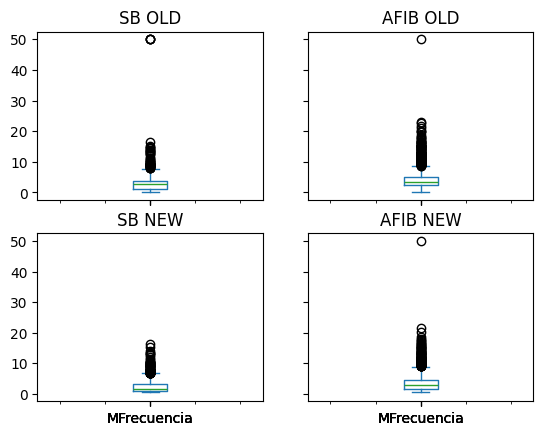

In [24]:
fig, axs = plt.subplots(2,2, sharey = True, sharex = True)
old_df[old_df.patologia == 'SB'].plot(kind='box', ax=axs[0,0], title='SB OLD')
old_df[old_df.patologia == 'AFIB'].plot(kind='box', ax=axs[0,1], title='AFIB OLD')
new_df[new_df.patologia == 'SB'].plot(kind='box', ax=axs[1,0], title='SB NEW')
new_df[new_df.patologia == 'AFIB'].plot(kind='box', ax=axs[1,1], title='AFIB NEW')

Podemos ver que, visualmente los AFIB parecen tener poca diferencia, al contrario de los pacientes SB, que presentan frecuencia máxima mas cercana al 0 con el procesamiento hecho por el autor respecto al procesamiento dado con el flujo 1. Aún asi para continuar comprobamos si estadisticamente existe dicha diferencia utilizando una prueba de hipotesis.

Es cierto que en su mayoria presentan un comportamiento similar, pero aun asi son notorias la existencia de diferencias.

Posteriormente, visualizando los diagramas de cajas y bigotes tenemos que:

SB OLD vs SB NEW:

* SB OLD: Las frecuencias máximas están más dispersas, con algunos valores atípicos (outliers) presentes en la parte superior.

* SB NEW: Las frecuencias máximas parecen estar más concentradas cerca de cero, mostrando menos dispersión y menos valores atípicos. Esto sugiere que el nuevo procesamiento ha reducido la variabilidad en las frecuencias máximas para los pacientes SB.

AFIB OLD vs AFIB NEW:

* AFIB OLD: Similar a SB OLD, muestra una mayor dispersión en las frecuencias máximas y varios valores atípicos.

* AFIB NEW: Aunque también muestra una mayor concentración cerca de cero como SB NEW, la diferencia visual entre AFIB OLD y AFIB NEW no es tan pronunciada como en los gráficos de SB. Esto indica que el nuevo procesamiento no ha afectado tanto a los datos de los pacientes con AFIB como a los de los pacientes con SB.

Para poder hacer esto necesitamos comprobar los supuestos, asumiendo independencia y probando con prueba de shapiro la normalidad y con prueba de levene si existe independencia de varianzas.

Utilizando la siguiente función se comprobaran los supuestos y en caso de recibir un valor false se utilizarán pruebas U, en caso contrario pruebas T.

In [25]:
from scipy import stats

def pruebaT_U(data1: np.ndarray, data2: np.ndarray) -> bool:
    '''
    Prueba si un ndarray es cumple los requisitos para hacer una prueba T de student o 
    en caso contrario se requiere hacer una prueba U de Mann-Whitney
    
    Se retorna un True en caso de que se pueda hacer una prueba T y falso en caso contrario.
    '''
    _, pV_1 = stats.shapiro(data1)
    _, pV_2 = stats.shapiro(data2)
    if pV_1 < 0.05 or pV_2 < 0.05:
        return False
    
    _, pV_3 = stats.levene(data1, data2)

    if pV_3 < 0.05:
        return False

    return True

afibN = new_df[new_df.patologia == 'AFIB'].MFrecuencia
afibO = old_df[old_df.patologia == 'AFIB'].MFrecuencia
sbN = new_df[new_df.patologia == 'SB'].MFrecuencia
sbO = old_df[old_df.patologia == 'SB'].MFrecuencia
print('¿Se puede usar prueba T con los resultados de AFIB?')
print(pruebaT_U(afibN, afibO))
print('¿Se puede usar prueba T con los resultados de SB?')
print(pruebaT_U(sbN, sbO))

¿Se puede usar prueba T con los resultados de AFIB?
False
¿Se puede usar prueba T con los resultados de SB?
False


Se procede con las pruebas U para tanto los resultados de AFIB como de SB

In [26]:
estadistico, p_value = stats.mannwhitneyu(afibN, afibO)
print(p_value)
if p_value > 0.05:
    print(f'No hay diferencias significativas en los resultados de AFIB.')
else:
    print(f'Hay diferencias significativas en los resultados de AFIB.')


7.174783587938002e-15
Hay diferencias significativas en los resultados de AFIB.


In [27]:
estadistico, p_value = stats.mannwhitneyu(sbN, sbO)
print(p_value)
if p_value > 0.05:
    print(f'No hay diferencias significativas en los resultados de SB.')
else:
    print(f'Hay diferencias significativas en los resultados de SB.')

1.0878489324707887e-29
Hay diferencias significativas en los resultados de SB.


Es importante tener en cuenta que las señales filtradas durante este proyecto no recibieron exactamente el mismo tratamiento que en el proyecto original. Esto es especialmente evidente en las diferencias significativas observadas entre esta señal y los procesos de otros flujos, en comparación con el flujo 1. Sin embargo, esto no implica que el flujo 1 haya sido siempre completamente exacto; de hecho, hubo pequeñas variaciones que podrían haber contribuido a la diferencia final observada.

Los parámetros como la recuencia de corte y el orden del filtro FIR tienen un impacto directo en cómo se modela y retiene la información de la señal ECG. En este proyecto, el filtro FIR pasa-altas de 0.5 Hz del Flujo 1 se eligió por su estabilidad y preservación de la fase, lo cual permite mantener la forma de la señal sin grandes alteraciones. 

8. Hacer un informe con todos los puntos anteriores (15%)

## **Conclusiones**

Los resultados de este análisis destacan la importancia de los métodos de filtrado en la precisión del análisis de señales ECG, especialmente para la caracterización de patologías específicas como la bradicardia sinusal y la fibrilación auricular. A partir de los hallazgos, se pueden concluir los siguientes puntos clave:

* Eficacia de los Métodos de Filtrado: El método Robust LOESS y el método Non-Local Means (NLM) demostraron ser efectivos en la reducción de ruido en señales ECG, cada uno enfocado en un tipo específico de ruido. La combinación de estos métodos permite conservar componentes esenciales en la señal mientras se elimina el ruido no deseado.

*  El Flujo 1 mostró mejor desempeño en la preservación de la forma de la señal ECG, logrando una adecuada eliminación de ruido sin alterar los componentes esenciales de la señal. Esto lo convierte en el flujo de procesamiento más recomendado para análisis ECG que requieren alta estabilidad y fidelidad en la señal filtrada.

*  La extracción de la fMP usando Welch fue efectiva en la identificación de patrones característicos de SB y AFIB, proporcionando una herramienta útil para la discriminación de estas patologías.

* La diferencia estadísticamente significativa en las frecuencias de máxima potencia en el grupo SB entre este proyecto y el anterior sugiere que los métodos aplicados de filtración de señales afectan sustancialmente la forma y distribución de frecuencias en esta patología, subrayando la importancia de la consistencia en el procesamiento de señales para estudios comparativos.




## **Bibliografía**


[1] Oh, H.-S., Nychka, D., Brown, T., & Charbonneau, P. (2004). Period analysis of variable stars by robust smoothing. Journal of the Royal Statistical Society. Series C, Applied Statistics, 53(1), 15–30. https://doi.org/10.1111/j.1467-9876.2004.00423.x

[2] Van De Ville, D., & Kocher, M. (2009). SURE-Based Non-Local Means. IEEE signal processing letters, 16(11), 973–976. https://doi.org/10.1109/lsp.2009.2027669

